Copyright (c) 2022, Hikmet Güner
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

<h1>Imports</h1>

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import normalize

from scipy.spatial.distance import cdist


<h2>Reading and Analyzing Data</h2>

In [23]:
df = pd.read_csv("exoplanets.csv",header=0, index_col=0)
df.head(10)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14
5,14 And b,14 And,0,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-07-23,2011-08,2014-07-23
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20
8,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2003-01,2014-08-21
9,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2008-04,2014-08-21


<h2>Checking Null Values</h2>

Calculating total amount of null values for insight, preparing for what's to come.

In [24]:
total_null_values = df.isnull().sum().sum()
total_null_values

916679

Iterating over columns to find the ratio of null values to total values.
If the ratio is greater than 0.7, the column will be dropped.

In [25]:
drop_columns = []
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if(na_ratio > 0.69):
        print(f"{name:<16} {na_ratio*100:.3f}%")
        drop_columns.append(name)

pl_orbsmaxerr1   87.165%
pl_orbsmaxerr2   87.168%
pl_radj          70.245%
pl_radjerr1      72.020%
pl_radjerr2      72.020%
pl_radjlim       70.245%
pl_bmasse        85.565%
pl_bmasseerr1    86.913%
pl_bmasseerr2    86.913%
pl_bmasselim     85.565%
pl_bmassj        85.568%
pl_bmassjerr1    86.932%
pl_bmassjerr2    86.932%
pl_bmassjlim     85.568%
pl_bmassprov     85.565%
pl_orbeccenerr1  92.074%
pl_orbeccenerr2  92.077%
pl_eqterr1       95.367%
pl_eqterr2       95.367%
st_spectype      94.197%


Adding the columns that are not useful for the model to the drop columns list

In [26]:
drop_columns.extend([
    'pl_name',
    'hostname',
    'default_flag',
    'discoverymethod',
    'disc_year',
    'disc_facility',
    'soltype',
    'pl_controv_flag',
    'pl_refname',
    'sy_refname',
    'rastr',
    'ra',
    'decstr',
    'dec',
    'rowupdate',
    'pl_pubdate',
    'releasedate',
    ])


Dropping columns that are related to the parent star, the data could be used for another analysis on how to detect stars that might have habitable planets within their systems.

In [27]:
drop_columns.extend([
    'st_refname',
    'st_teff',
    'st_tefferr1',
    'st_tefferr2',
    'st_tefflim',
    'st_rad',
    'st_raderr1',
    'st_raderr2',
    'st_radlim',
    'st_mass',
    'st_masserr1',
    'st_masserr2',
    'st_masslim',
    'st_met',
    'st_meterr1',
    'st_meterr2',
    'st_metlim',
    'st_metratio',
    'st_logg',
    'st_loggerr1',
    'st_loggerr2',
    'st_logglim',
    'sy_vmag',
    'sy_vmagerr1',
    'sy_vmagerr2',
    'sy_kmag',
    'sy_kmagerr1',
    'sy_kmagerr2',
    'sy_gaiamag',
    'sy_gaiamagerr1',
    'sy_gaiamagerr2'
    ])


index = 0
for columns in drop_columns:
    if index % 3 == 0:
        print()
    print(f'{columns:<20}', end='')
    index += 1


pl_orbsmaxerr1      pl_orbsmaxerr2      pl_radj             
pl_radjerr1         pl_radjerr2         pl_radjlim          
pl_bmasse           pl_bmasseerr1       pl_bmasseerr2       
pl_bmasselim        pl_bmassj           pl_bmassjerr1       
pl_bmassjerr2       pl_bmassjlim        pl_bmassprov        
pl_orbeccenerr1     pl_orbeccenerr2     pl_eqterr1          
pl_eqterr2          st_spectype         pl_name             
hostname            default_flag        discoverymethod     
disc_year           disc_facility       soltype             
pl_controv_flag     pl_refname          sy_refname          
rastr               ra                  decstr              
dec                 rowupdate           pl_pubdate          
releasedate         st_refname          st_teff             
st_tefferr1         st_tefferr2         st_tefflim          
st_rad              st_raderr1          st_raderr2          
st_radlim           st_mass             st_masserr1         
st_masserr2         st_

Dropping columns from the dataset

In [28]:
df = df.drop(columns=drop_columns)
df.head()

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxlim,pl_rade,pl_radeerr1,...,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqtlim,ttv_flag,sy_dist,sy_disterr1,sy_disterr2
0,2,1,326.03000,0.32,-0.32,0.0,1.29,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,93.1846,1.9238,-1.9238
1,2,1,NaN,NaN,NaN,NaN,1.21,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,93.1846,1.9238,-1.9238
2,1,1,NaN,NaN,NaN,NaN,1.51,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
3,1,1,516.21997,3.20,-3.20,0.0,1.53,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
4,1,1,516.22000,3.25,-3.25,0.0,1.54,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765


In [29]:
null_after_dropcol = df.isnull().sum().sum()
null_after_dropcol

214945

Dealing with rows with many missing data

Finding how much column is missing from each row

In [30]:
empty_col_per_row = {i: 0 for i in df.index}
for col in df.columns:
    total_nan = 0
    for index in df.index:
        if pd.isna(df[col][index]):
            empty_col_per_row[index] += 1
empty_col_per_row

{0: 10,
 1: 16,
 2: 16,
 3: 10,
 4: 10,
 5: 16,
 6: 10,
 7: 10,
 8: 10,
 9: 12,
 10: 14,
 11: 10,
 12: 10,
 13: 10,
 14: 10,
 15: 10,
 16: 10,
 17: 10,
 18: 10,
 19: 10,
 20: 10,
 21: 10,
 22: 16,
 23: 14,
 24: 14,
 25: 14,
 26: 12,
 27: 10,
 28: 10,
 29: 10,
 30: 14,
 31: 19,
 32: 14,
 33: 16,
 34: 15,
 35: 19,
 36: 14,
 37: 14,
 38: 12,
 39: 12,
 40: 9,
 41: 16,
 42: 10,
 43: 10,
 44: 10,
 45: 10,
 46: 10,
 47: 10,
 48: 10,
 49: 10,
 50: 10,
 51: 10,
 52: 10,
 53: 10,
 54: 10,
 55: 10,
 56: 10,
 57: 10,
 58: 14,
 59: 10,
 60: 10,
 61: 12,
 62: 10,
 63: 10,
 64: 12,
 65: 10,
 66: 10,
 67: 10,
 68: 10,
 69: 10,
 70: 10,
 71: 10,
 72: 10,
 73: 10,
 74: 10,
 75: 10,
 76: 10,
 77: 10,
 78: 10,
 79: 10,
 80: 10,
 81: 10,
 82: 10,
 83: 10,
 84: 10,
 85: 10,
 86: 10,
 87: 10,
 88: 10,
 89: 10,
 90: 10,
 91: 10,
 92: 10,
 93: 10,
 94: 10,
 95: 14,
 96: 10,
 97: 18,
 98: 10,
 99: 12,
 100: 4,
 101: 10,
 102: 10,
 103: 8,
 104: 6,
 105: 8,
 106: 10,
 107: 6,
 108: 12,
 109: 10,
 110: 10,
 111: 

Checking how it compares to the amount of rows 

In [31]:
print(max(empty_col_per_row.values()))
print(min(empty_col_per_row.values()))
print(len(df.columns))

21
0
24


Computing null ratio to compare it after dropping rows

In [32]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio:.5f}")

pl_orbsmax       0.44160
pl_orbsmaxlim    0.35844
pl_rade          0.30232
pl_radeerr1      0.32142
pl_radeerr2      0.32142
pl_orbeccen      0.48851
pl_orbeccenlim   0.40637
pl_insol         0.57883
pl_insolerr1     0.58516
pl_insolerr2     0.58516
pl_insollim      0.43248
pl_eqt           0.54749
pl_eqtlim        0.47091


Dropping rows missing over %50 columns

In [33]:
before_drop = len(df.index)
for index, nan_val in empty_col_per_row.items():
    if (nan_val) > 14:
        df = df.drop(index)
before_drop - len(df.index)

985

Computing total nulls after drop

In [34]:
null_after_dropcol = df.isnull().sum().sum()
null_after_dropcol

198759

Computing null ratio again

In [35]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio:.5f}")

pl_orbsmax       0.43504
pl_orbsmaxlim    0.35037
pl_radeerr1      0.30041
pl_radeerr2      0.30041
pl_orbeccen      0.47423
pl_orbeccenlim   0.38952
pl_insol         0.56569
pl_insolerr1     0.57221
pl_insolerr2     0.57221
pl_insollim      0.41477
pl_eqt           0.53388
pl_eqtlim        0.45491


Filling Empty Columns
#TODO fill missing values, and decide what to do with error margins

In [36]:
fill_columns = []
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio < 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio:.5f}")
        fill_columns.append(name)

pl_orbper        0.07343
pl_orbpererr1    0.10454
pl_orbpererr2    0.10457
pl_orbperlim     0.07327
pl_rade          0.28150
pl_radelim       0.19682
sy_dist          0.01951
sy_disterr1      0.03957
sy_disterr2      0.03957


In [37]:
#for col in fill_columns:
    #df[col] = df[col].fillna(0, inplace= False)

In [38]:
for col in fill_columns:
    print(df[col].head())

0     326.03000
3     516.21997
4     516.22000
6     185.84000
7    1766.41000
Name: pl_orbper, dtype: float64
0    0.32
3    3.20
4    3.25
6    0.23
7    0.67
Name: pl_orbpererr1, dtype: float64
0   -0.32
3   -3.20
4   -3.25
6   -0.23
7   -0.68
Name: pl_orbpererr2, dtype: float64
0    0.0
3    0.0
4    0.0
6    0.0
7    0.0
Name: pl_orbperlim, dtype: float64
0   NaN
3   NaN
4   NaN
6   NaN
7   NaN
Name: pl_rade, dtype: float64
0   NaN
3   NaN
4   NaN
6   NaN
7   NaN
Name: pl_radelim, dtype: float64
0     93.1846
3    125.3210
4    125.3210
6     75.4392
7     17.9323
Name: sy_dist, dtype: float64
0    1.9238
3    1.9765
4    1.9765
6    0.7140
7    0.0073
Name: sy_disterr1, dtype: float64
0   -1.9238
3   -1.9765
4   -1.9765
6   -0.7140
7   -0.0073
Name: sy_disterr2, dtype: float64


In [39]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio:.5f}")

pl_orbsmax       0.43504
pl_orbsmaxlim    0.35037
pl_radeerr1      0.30041
pl_radeerr2      0.30041
pl_orbeccen      0.47423
pl_orbeccenlim   0.38952
pl_insol         0.56569
pl_insolerr1     0.57221
pl_insolerr2     0.57221
pl_insollim      0.41477
pl_eqt           0.53388
pl_eqtlim        0.45491


In [40]:
#scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.isna().sum()

sy_snum               0
sy_pnum               0
pl_orbper          2318
pl_orbpererr1      3300
pl_orbpererr2      3301
pl_orbperlim       2313
pl_orbsmax        13733
pl_orbsmaxlim     11060
pl_rade            8886
pl_radeerr1        9483
pl_radeerr2        9483
pl_radelim         6213
pl_orbeccen       14970
pl_orbeccenlim    12296
pl_insol          17857
pl_insolerr1      18063
pl_insolerr2      18063
pl_insollim       13093
pl_eqt            16853
pl_eqtlim         14360
ttv_flag              0
sy_dist             616
sy_disterr1        1249
sy_disterr2        1249
dtype: int64

In [41]:
print(df['pl_orbeccen'].mean())
print(df['pl_orbeccen'].max())
print(df['pl_orbeccen'].min())

0.03558094896668072
0.97
0.0


In [42]:
imputer = KNNImputer(n_neighbors=10)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [43]:
print(df['pl_orbeccen'].mean())
print(df['pl_orbeccen'].max())
print(df['pl_orbeccen'].min())

0.027691547945639428
0.97
0.0


In [44]:
df.isna().sum()
df.head()

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxlim,pl_rade,pl_radeerr1,...,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqtlim,ttv_flag,sy_dist,sy_disterr1,sy_disterr2
0,2.0,1.0,326.03000,0.32,-0.32,0.0,1.29,0.0,3.5057,0.3763,...,502.585,204.740,-126.155,0.0,758.0,0.0,0.0,93.1846,1.9238,-1.9238
1,1.0,1.0,516.21997,3.20,-3.20,0.0,1.53,0.0,3.0776,0.4190,...,475.662,204.384,-125.773,0.0,674.4,0.0,0.0,125.3210,1.9765,-1.9765
2,1.0,1.0,516.22000,3.25,-3.25,0.0,1.54,0.0,3.0776,0.4190,...,475.662,204.384,-125.773,0.0,674.4,0.0,0.0,125.3210,1.9765,-1.9765
3,1.0,1.0,185.84000,0.23,-0.23,0.0,0.83,0.0,3.0338,0.3699,...,475.527,204.471,-125.912,0.0,455.3,0.0,0.0,75.4392,0.7140,-0.7140
4,1.0,2.0,1766.41000,0.67,-0.68,0.0,2.83,0.0,5.8784,0.4477,...,479.594,204.537,-125.981,0.0,812.7,0.0,0.0,17.9323,0.0073,-0.0073


In [45]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(df)
    kmeanModel.fit(df)
  
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / df.shape[0]
    mapping2[k] = kmeanModel.inertia_

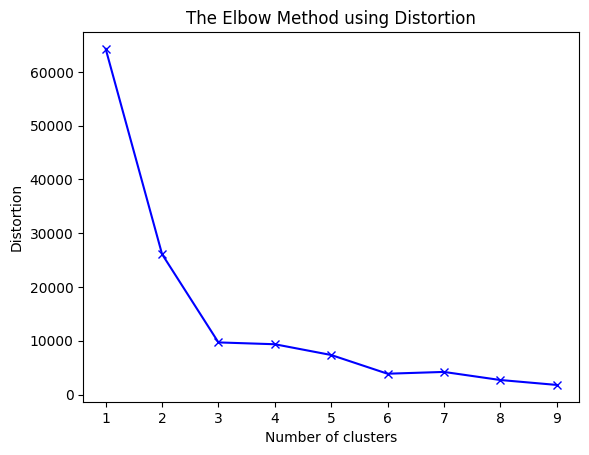

In [46]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

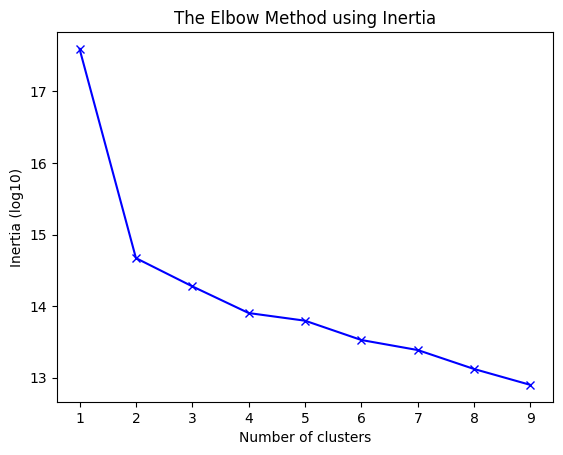

In [47]:
plt.plot(K, np.log10(inertias), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (log10)')
plt.title('The Elbow Method using Inertia')
plt.show()